目前你见过的所有神经网络（比如**全连接网络**和**卷积神经网络**）都有一个主要特点，那就是**它们都没有记忆**。

它们**单独处理每个输入，在输入与输入之间没有保存任何状态**。对于这样的网络，**要想处理数据点的序列或时间序列，你需要向网络同时展示整个序列，即将序列转换成单个数据点**。例如，你在 `IMDB` 示例中就是这么做的：**将全部电影评论转换为一个大向量，然后一次性处理**。这种网络叫作**前馈网络（feedforward network）**。

与此相反，当你在阅读这个句子时，你是一个词一个词地阅读（或者说，眼睛一次扫视一次扫视地阅读），同时会记住之前的内容。这让你能够动态理解这个句子所传达的含义。生物智能以渐进的方式处理信息，同时保存一个关于所处理内容的内部模型，这个模型是根据过去的信息构建的，并随着新信息的进入而不断更新。

循环神经网络（`RNN， recurrent neural network`）采用同样的原理，：它处理序列的方式是，**遍历所有序列元素，并保存一个状态（state），其中包含与已查看内容相关的信息。实际上， RNN 是一类具有内部环的神经网络。在处理两个不同的独立序列（比如两条不同的 IMDB 评论）之间， RNN 状态会被重置，因此，你仍可以将一个序列看作单个数据点，即网络的单个输入**。真正改变的是，**数据点不再是在单个步骤中进行处理，相反，网络内部会对序列元素进行遍历。**

![image.png](../img/06/循环网络结构图.png)

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

为了将环（`loop`）和`状态`的概念解释清楚，我们用 `Numpy` 来实现一个简单 `RNN` 的前向传递。这个 `RNN` 的输入是一个张量序列，我们将其编码成大小为 (`timesteps, input_features`)的二维张量。它对时间步（`timestep`）进行遍历，在每个时间步，它考虑 `t` 时刻的当前状态与`t`时刻的输入［形状为 `(input_ features,)`］，对二者计算得到 `t` 时刻的输出。然后，我们将下一个时间步的状态设置为上一个时间步的输出。对于第一个时间步，上一个时间步的输出没有定义，所以它没有当前状态。因此，你需要将状态初始化为一个全零向量，这叫作网络的初始状态（`initial state`）。


**RNN 的伪代码如下所示。**

In [2]:
# # RNN 伪代码

# state_t = 0                                                         # t 时刻的状态
# for input_t in input_sequence:                                      # 对序列元素进行遍历
#     output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
#     state_t = output_t                                              # 前一次的输出变成下一次迭代的状态

In [3]:
# # 简单 RNN 的 Numpy 实现

# import numpy as np
# timesteps = 100                                                      # 输入序列的时间步数
# input_features = 32                                                  # 输入特征空间的维度
# output_features = 64                                                 # 输出特征空间的维度
# inputs = np.random.random((timesteps, input_features))               # 输入数据：随机噪声，仅作为示例
# state_t = np.zeros((output_features,))                               # 初始状态：全零向量

# # 创建随机的权重矩阵
# W = np.random.random((output_features, input_features))
# U = np.random.random((output_features, output_features))
# b = np.random.random((output_features,))
# successive_outputs = []
# # input_t 是形状为 (input_features,) 的向量
# for input_t in inputs:
#     # 由输入和当前状态（前一个输出）计算得到当前输出
#     output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
#     # 将这个输出保存到一个列表中
#     successive_outputs.append(output_t)
#     # 更新网络的状态，用于下一个时间步
#     state_t = output_t
# # 最终输出是一个形状为 (timesteps,output_features) 的二维张量
# final_output_sequence = np.stack(successive_outputs, axis=0)

RNN 是一个 `for` 循环，它重复使用**循环前一次迭代的计算结果**。当然，你**可以构建许多不同的 RNN**，它们都满足上述定义。这个例子只是最简单的 `RNN` 表述之一。**RNN 的特征在于其时间步函数，比如前面例子中的这个函数**

```python
output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
```

![image.png](../img/06/简单的RNN沿时间展开.png)

-----------------------------------------------------------------

> 注意 本例中，最终输出是一个形状为 `(timesteps, output_features)` 的二维张量，其中每个时间步是循环在 `t` 时刻的输出。输出张量中的每个时间步 `t` 包含输入序列中时间步 `0~t` 的信息，即关于全部过去的信息。因此，在多数情况下，你并不需要这个所有输出组成的序列，你只需要最后一个输出（循环结束时的 `output_t`），因为它已经包含了整个序列的信息。

--------------------------------------------------------------

# 1 Keras 中的循环层

上面 `Numpy` 的简单实现，对应一个实际的 `Keras` 层，即 `SimpleRNN` 层

`SimpleRNN` 层能够像其他 `Keras` 层一样处理序列批量，而不是像 `Numpy` 示例那样只能处理单个序列。因此，它接收形状为 `(batch_size, timesteps,input_features)` 的输入，而不是 `(timesteps, input_features)`。

与 Keras 中的所有循环层一样， SimpleRNN 可以在两种不同的模式下运行：
* 一种是**返回每个时间步连续输出的完整序列**，即形状为 `(batch_size, timesteps, output_features)`的三维张量；
* 另一种是**只返回每个输入序列的最终输出**，即形状为 `(batch_size, output_features)` 的二维张量。

这两种模式由 `return_sequences` 这个构造函数参数来控制。

In [6]:
from keras.layers import SimpleRNN

# 只返回最后一个时间步的输出
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [8]:
# 返回完整的状态序列
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [9]:
# 为了提高网络的表示能力，将多个循环层逐个堆叠有时也是很有用的。
# 在这种情况下，你需要让所有中间层都返回完整的输出序列。

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


## 将这个模型应用于 IMDB 电影评论分类问题

In [10]:
# 准备 IMDB 数据

from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # 作为特征的单词个数
maxlen = 500          # 在这么多单词之后截断文本（这些单词都属于前 max_features 个最常见的单词）
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [11]:
# 用 Embedding 层和 SimpleRNN 层来训练模型

from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 89s 4ms/step - loss: 0.6427 - acc: 0.6115 - val_loss: 0.5746 - val_acc: 0.6954
Epoch 2/10
20000/20000 [==============================] - 51s 3ms/step - loss: 0.4291 - acc: 0.8132 - val_loss: 0.4430 - val_acc: 0.8022
Epoch 3/10
20000/20000 [==============================] - 35s 2ms/step - loss: 0.3047 - acc: 0.8763 - val_loss: 0.4097 - val_acc: 0.8120
Epoch 4/10
20000/20000 [==============================] - 34s 2ms/step - loss: 0.2145 - acc: 0.9170 - val_loss: 0.4537 - val_acc: 0.7962
Epoch 5/10
20000/20000 [==============================] - 32s 2ms/step - loss: 0.1515 - acc: 0.9461 - val_loss: 0.4009 - val_acc: 0.8640
Epoch 6/10
20000/20000 [==============================] - 33s 2ms/step - loss: 0.0969 - acc: 0.9670 - val_loss: 0.4252 - val_acc: 0.8426
Epoch 7/10
20000/20000 [==============================] - 31s 2ms/step - loss: 0.0624 - acc: 0.9805 - val_loss: 0.4634 - val_acc:

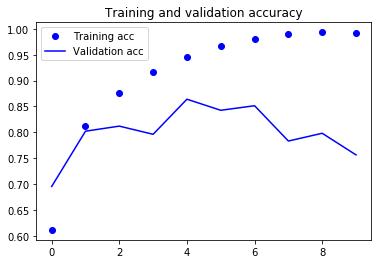

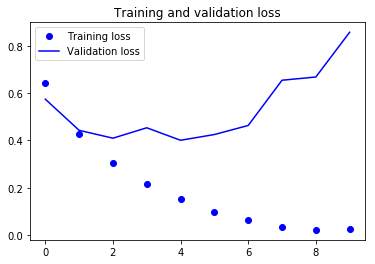

In [12]:
# 显示训练和验证的损失和精度
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

在第 3 章，处理这个数据集的第一个简单方法得到的测试精度是 88%。不幸的是，与这个基准相比，这个小型循环网络的表现并不好（验证精度只有 85%）。

* 问题的部分原因在于，**输入只考虑了前 500 个单词，而不是整个序列， 因此， RNN 获得的信息比前面的基准模型更少**。

* 另一部分原因在于， **SimpleRNN 不擅长处理长序列，比如文本**。

其他类型的循环层的表现要好得多

# 2 理解 LSTM 层和 GRU 层

* SimpleRNN 并不是 Keras 中唯一可用的循环层，还有另外两个： LSTM 和 GRU。在实践中总会用到其中之一，因为 SimpleRNN 通常过于简化，没有实用价值。 

* SimpleRNN 的最大问题是，**在时刻 t，理论上来说，它应该能够记住许多时间步之前见过的信息，但实际上它是不可能学到这种长期依赖的。其原因在于梯度消失问题（vanishing gradient problem），这一效应类似于在层数较多的非循环网络（即前馈网络）中观察到的效应：随着层数的增加，网络最终变得无法训练**。LSTM 层和 GRU 层都是为了解决这个问题而设计的。

* LSTM 层。其背后的长短期记忆（LSTM， long short-term memory）算法由 Hochreiter和 Schmidhuber 在 1997 年开发，是二人**研究梯度消失问题的重要成果**。

* LSTM 层是 SimpleRNN 层的一种变体，它增加了一种**携带信息跨越多个时间步的方法。假设有一条传送带，其运行方向平行于你所处理的序列。序列中的信息可以在任意位置跳上传送带，然后被传送到更晚的时间步，并在需要时原封不动地跳回来**。这实际上就是 LSTM 的原理：**它保存信息以便后面使用，从而防止较早期的信号在处理过程中逐渐消失**。

为了详细了解 LSTM，我们先从 SimpleRNN 单元开始讲起（见图）。因为有许多个权重矩阵，所以对单元中的 W 和 U 两个矩阵添加下标字母 o（Wo 和 Uo），表示输出。

![image.png](../img/06/讨论LSTM层出发点SimpleRNN层.PNG)

向这张图像中添加额外的数据流，其中**携带着跨越时间步的信息。它在不同的时间步的值叫作 Ct，其中 C 表示携带（carry）。这些信息将会对单元产生以下影响**：它**将与输入连接和循环连接进行运算（通过一个密集变换，即与权重矩阵作点积，然后加上一个偏置，再应用一个激活函数），从而影响传递到下一个时间步的状态（通过一个激活函数和一个乘法运算）**。

从概念上来看，**携带数据流是一种调节下一个输出和下一个状态的方法（见图）**。到目前为止都很简单。

![image.png](../img/06/从SimpleRNN到LSTM添加一个携带轨道.PNG)

携带数据流下一个值的计算方法。它涉及三个不同的变换，这三个变换的形式都和 `SimpleRNN` 单元相同。
但这三个变换都具有各自的权重矩阵，我们分别用字母 i、 j 和 k 作为下标。
```python
y = activation(dot(state_t, U) + dot(input_t, W) + b)
```

* LSTM 架构的详细伪代码（1/2）
```python
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(C_t, Vo) + bo)
i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)
```

对i_t、f_t和k_t进行组合，可以得到新的携带状态（下一个c_t）

* LSTM 架构的详细伪代码（2/2）
```python
c_t+1 = i_t * k_t + c_t * f_t
```

添加上述架构之后的图示,如果要更哲学一点，还可以解释每个运算的目的。比如可以说，

* 将 **c_t 和 f_t 相乘，是为了故意遗忘携带数据流中的不相关信息**。
* **i_t 和 k_t 都提供关于当前的信息，可以用新信息来更新携带轨道**。
* 但归根结底，这些解释并没有多大意义，因为**这些运算的实际效果是由参数化权重决定的，而权重是以端到端的方式进行学习，每次训练都要从头开始，不可能为某个运算赋予特定的目的**。 
* RNN 单元的类型（如前所述）决定了你的假设空间，即在训练期间搜索良好模型配置的空间，但它不能决定 RNN 单元的作用，那是由单元权重来决定的。同一个单元具有不同的权重，可以实现完全不同的作用。因此，**组成 RNN 单元的运算组合，最好被解释为对搜索的一组约束，而不是一种工程意义上的设计**。

对于研究人员来说，这种**约束的选择（即如何实现 RNN 单元）似乎最好是留给最优化算法来完成（比如遗传算法或强化学习过程），而不是让人类工程师来完成**。

在未来，那将是我们构建网络的方式。总之，你**不需要理解关于 LSTM 单元具体架构的任何内容**。作为人类，理解它不应该是你要做的。

只需要记住 LSTM 单元的作用：**允许过去的信息稍后重新进入，从而解决梯度消失问题**。

![image.png](../img/06/剖析LSTM.png)

# 3 Keras 中一个 LSTM 的具体例子

使用 LSTM 层来创建一个模型，然后在 IMDB 数据上训练模型。 这个网络与前面介绍的 SimpleRNN 网络类似。你只需指定
LSTM 层的输出维度，其他所有参数（有很多）都使用 Keras 默认值。 Keras 具有很好的默认值，无须手动调参，模型通常也能正常运行。

In [13]:
# 使用 Keras 中的 LSTM 层

from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 125s 6ms/step - loss: 0.5102 - acc: 0.7611 - val_loss: 0.3766 - val_acc: 0.8390
Epoch 2/10
20000/20000 [==============================] - 121s 6ms/step - loss: 0.2939 - acc: 0.8840 - val_loss: 0.3774 - val_acc: 0.8286
Epoch 3/10
20000/20000 [==============================] - 132s 7ms/step - loss: 0.2326 - acc: 0.9098 - val_loss: 0.2915 - val_acc: 0.8910
Epoch 4/10
20000/20000 [==============================] - 117s 6ms/step - loss: 0.1947 - acc: 0.9263 - val_loss: 0.4053 - val_acc: 0.8808
Epoch 5/10
20000/20000 [==============================] - 119s 6ms/step - loss: 0.1725 - acc: 0.9356 - val_loss: 0.2884 - val_acc: 0.8902
Epoch 6/10
20000/20000 [==============================] - 122s 6ms/step - loss: 0.1526 - acc: 0.9438 - val_loss: 0.4851 - val_acc: 0.8394
Epoch 7/10
20000/20000 [==============================] - 121s 6ms/step - loss: 0.1399 - acc: 0.9505 - val_loss: 0.3635 - v

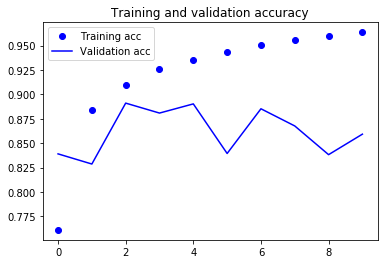

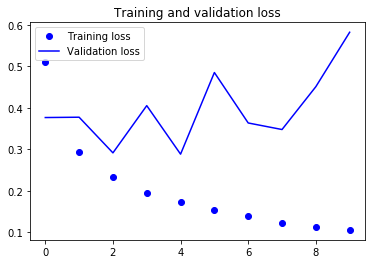

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

这一次，验证精度达到了 89%。还不错，肯定比 SimpleRNN 网络好多了，这主要是因为LSTM 受梯度消失问题的影响要小得多。这个结果也比第 3 章的全连接网络略好，虽然使用的数据量比第 3 章要少。此处在 500 个时间步之后将序列截断，而在第 3 章是读取整个序列。但对于一种计算量如此之大的方法而言，这个结果也说不上是突破性的。

**为什么 LSTM 不能表现得更好？**
* 一个原因是你没有花力气来调节超参数，比如嵌入维度或 LSTM 输出维度
* 另一个原因可能是缺少正则化。

主要原因在于，**适用于评论分析全局的长期性结构（这正是 LSTM 所擅长的），对情感分析问题帮助不大**。
对于这样的基本问题，观察每条评论中出现了哪些词及其出现频率就可以很好地解决。这也正是第一个全连接方法的做法。但还有更加困难的自然语言处理问题，特别是问答和机器翻译，这时 LSTM 的优势就明显了。